## Introduction 

This updated analysis builds on the previous anlaysis by repeating the same steps with a larger dataset, incorporating data from additional darts tournaments. By increasing the dataset size, we aim to enhance the reliability of findings, validate trends observed in the initial analysis, and improve the robustness of predictive modeling.

## Dataset Overview and Source *[v2: larger dataset]*
The dataset comprises performance metrics from two recent darts tournaments, the Players Championship Finals and the Grand Slam of Darts, sourced from [Flashscore.co.uk](https://www.flashscore.co.uk). These metrics will be analysed and used to build a predictive model for match outcomes.


In [1]:
import os 
import pandas as pd

# Change folder  
os.chdir("/Users/samharrison/Documents/data_sci/darts")

df = pd.read_csv("data/darts_data_v2.csv")
df.head()

,tournament,round,player1,player2,legs_score,sets_score,p1_three_dart_avg,p2_three_dart_avg,p1_checkouts,p2_checkouts
0,Players Championship Finals 2024,R64,Gian van Veen,Scott Williams,5-6,n.a,104.21,97.64,5/10,6/11
1,Players Championship Finals 2024,R64,Andrew Gilding,Kevin Doets,6-3,n.a,97.14,94.16,6/14,3/15
2,Players Championship Finals 2024,R64,William O'Connor,Niels Zonneveld,3-6,n.a,88.83,97.57,3/11,6/11
3,Players Championship Finals 2024,R64,Brendan Dolan,Martin Schindler,2-6,n.a,78.46,83.91,2/6,6/13
4,Players Championship Finals 2024,R64,Krzysztof Ratajski,Madars Razma,6-4,n.a,96.16,93.77,6/11,4/14


In [2]:
df.describe()

,p1_three_dart_avg,p2_three_dart_avg
count,140.000000,140.000000
mean,94.027500,93.668643
std,6.614692,6.044706
min,78.460000,76.130000
25%,89.825000,89.987500
50%,94.195000,94.270000
75%,98.362500,97.690000
max,112.730000,107.080000


## Feature Engineering for Player Performance

### I. Legs Won Comparison

Number of legs won by each player and calculates the ratio to show Player 1's dominance over Player 2.

In [3]:
# Extract legs won for each player
df[['p1_legs', 'p2_legs']] = df['legs_score'].str.split('-', expand=True).astype(float)

# Ensure all values are treated as strings before replacing
df['sets_score'] = df['sets_score'].astype(str).replace('n.a', pd.NA)

# Extract sets won for each player (only when data exists)
df[['p1_sets', 'p2_sets']] = df['sets_score'].str.split('-', expand=True)

# Convert to float, handling any missing values
df[['p1_sets', 'p2_sets']] = df[['p1_sets', 'p2_sets']].apply(pd.to_numeric, errors='coerce')

# Create 'winner' column based on sets first, then legs if sets are missing
def determine_winner(row):
    if not pd.isna(row['p1_sets']) and not pd.isna(row['p2_sets']):
        return 'player1' if row['p1_sets'] > row['p2_sets'] else 'player2'
    else:
        return 'player1' if row['p1_legs'] > row['p2_legs'] else 'player2'

df['winner'] = df.apply(determine_winner, axis=1)

# Calculate the ratio of legs won between players (regardless of sets)
df['p1_to_p2_legs_ratio'] = df['p1_legs'] / (df['p1_legs'] + df['p2_legs'])

# Preview the results
df[['p1_legs', 'p2_legs', 'p1_to_p2_legs_ratio', 'p1_sets', 'p2_sets', 'winner']]

,p1_legs,p2_legs,p1_to_p2_legs_ratio,p1_sets,p2_sets,winner
0,5.0,6.0,0.454545,NaN,NaN,player2
1,6.0,3.0,0.666667,NaN,NaN,player1
2,3.0,6.0,0.333333,NaN,NaN,player2
3,2.0,6.0,0.250000,NaN,NaN,player2
4,6.0,4.0,0.600000,NaN,NaN,player1
...,...,...,...,...,...,...
135,16.0,10.0,0.615385,NaN,NaN,player1
136,16.0,7.0,0.695652,NaN,NaN,player1
137,17.0,10.0,0.629630,NaN,NaN,player1
138,17.0,13.0,0.566667,NaN,NaN,player1


### II. Checkout Efficiency Comparison

Successful checkouts, attempts, and rates are calculated to compare the players' finishing efficiency.

In [4]:
# Extract successful checkouts and attempts for each player
df[['p1_successful_checkouts', 'p1_checkout_attempts']] = df['p1_checkouts'].str.split('/', expand=True).astype(float)
df[['p2_successful_checkouts', 'p2_checkout_attempts']] = df['p2_checkouts'].str.split('/', expand=True).astype(float)

# Exclude rows to avoid few checkout attempts to avoid misleading checkout rates
df = df[(df['p1_checkout_attempts'] >= 7) & (df['p2_checkout_attempts'] >= 7)]

# Calculate checkout rates for each player
df['p1_checkout_rate'] = df['p1_successful_checkouts'] / df['p1_checkout_attempts']
df['p2_checkout_rate'] = df['p2_successful_checkouts'] / df['p2_checkout_attempts']

# Calculate the difference in checkout rates between players
df['delta_checkout_rate'] = df['p1_checkout_rate'] - df['p2_checkout_rate']
df[['p1_checkout_rate', 'p2_checkout_rate', 'delta_checkout_rate']].head(3)

,p1_checkout_rate,p2_checkout_rate,delta_checkout_rate
0,0.500000,0.545455,-0.045455
1,0.428571,0.200000,0.228571
2,0.272727,0.545455,-0.272727


### III. Scoring Ability Comparison (based on three dart average)

The difference in three-dart averages highlights the players' scoring ability.

In [5]:
# Calculate the difference in three-dart averages between players
df['delta_three_dart_avg'] = df['p1_three_dart_avg'] - df['p2_three_dart_avg']
df[['p1_three_dart_avg', 'p2_three_dart_avg', 'delta_three_dart_avg']].head(3)
df.describe()

,p1_three_dart_avg,p2_three_dart_avg,p1_legs,p2_legs,p1_sets,p2_sets,p1_to_p2_legs_ratio,p1_successful_checkouts,p1_checkout_attempts,p2_successful_checkouts,p2_checkout_attempts,p1_checkout_rate,p2_checkout_rate,delta_checkout_rate,delta_three_dart_avg
count,117.000000,117.000000,117.000000,117.000000,28.000000,28.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000
mean,93.713504,94.197607,7.769231,7.923077,1.857143,1.892857,0.480514,7.769231,20.504274,7.923077,20.247863,0.385007,0.406766,-0.021760,-0.484103
std,6.199612,5.290824,4.218973,3.552934,1.406711,1.196887,0.158505,4.218973,10.456498,3.552934,8.794499,0.135804,0.127329,0.204966,5.238106
min,79.650000,80.790000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,7.000000,1.000000,7.000000,0.000000,0.076923,-0.666667,-12.660000
25%,89.330000,91.190000,5.000000,6.000000,1.000000,1.000000,0.375000,5.000000,12.000000,6.000000,14.000000,0.285714,0.315789,-0.151316,-3.610000
50%,94.130000,94.510000,7.000000,7.000000,2.000000,2.000000,0.473684,7.000000,18.000000,7.000000,19.000000,0.384615,0.384615,-0.019841,-0.560000
75%,97.420000,97.840000,10.000000,10.000000,3.000000,2.250000,0.600000,10.000000,26.000000,10.000000,25.000000,0.454545,0.478261,0.090909,2.580000
max,108.760000,105.260000,20.000000,25.000000,5.000000,6.000000,0.857143,20.000000,57.000000,25.000000,59.000000,0.857143,0.833333,0.590476,15.780000


### Summary 

Following feature engineering, we have developed player performance metrics that capture differences in checkout rates and three-dart averages. Next, we will consider the distributions of these performance metrics and the match outcome variables.

In [6]:
# Preview the selected features and target
df[['delta_checkout_rate', 'delta_three_dart_avg', 'p1_to_p2_legs_ratio', 'winner']].head(3)

,delta_checkout_rate,delta_three_dart_avg,p1_to_p2_legs_ratio,winner
0,-0.045455,6.57,0.454545,player2
1,0.228571,2.98,0.666667,player1
2,-0.272727,-8.74,0.333333,player2


In [7]:
df[['delta_checkout_rate', 'delta_three_dart_avg', 'p1_to_p2_legs_ratio']].describe()

,delta_checkout_rate,delta_three_dart_avg,p1_to_p2_legs_ratio
count,117.000000,117.000000,117.000000
mean,-0.021760,-0.484103,0.480514
std,0.204966,5.238106,0.158505
min,-0.666667,-12.660000,0.000000
25%,-0.151316,-3.610000,0.375000
50%,-0.019841,-0.560000,0.473684
75%,0.090909,2.580000,0.600000
max,0.590476,15.780000,0.857143


## Data Visualisation

### I. Player Performance Metrics

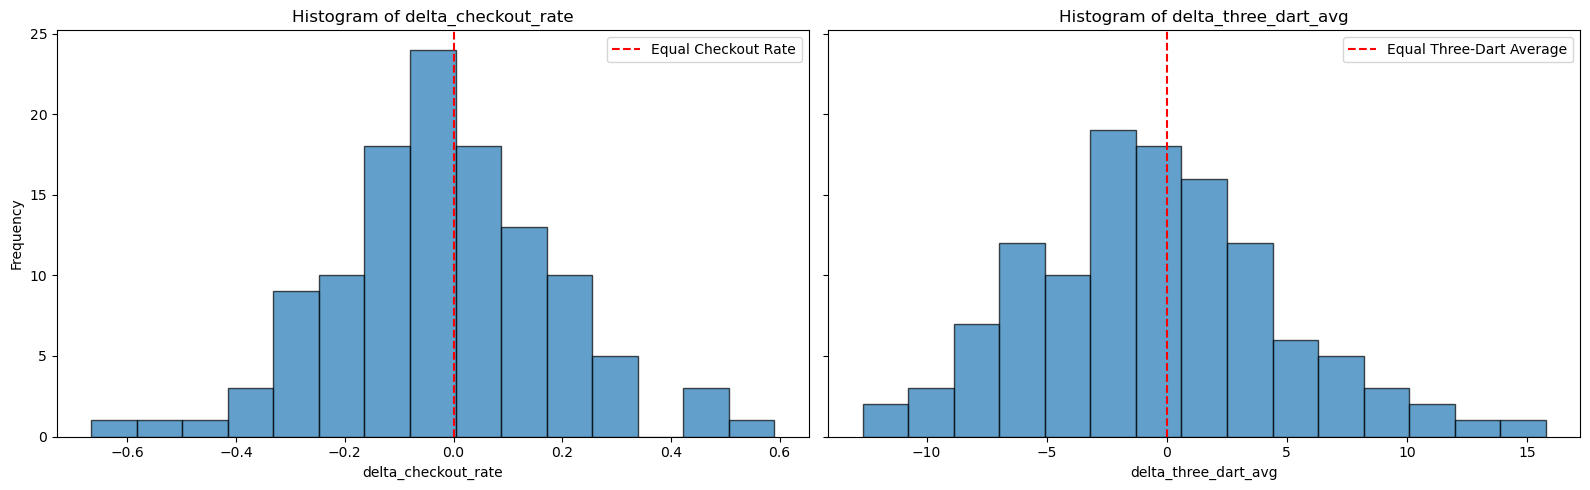

In [8]:
import matplotlib.pyplot as plt

# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

# Plot histogram for delta_checkout_rate
axes[0].hist(df['delta_checkout_rate'], bins=15, alpha=0.7, edgecolor='black')
axes[0].set_title('Histogram of delta_checkout_rate')
axes[0].set_xlabel('delta_checkout_rate')
axes[0].set_ylabel('Frequency')
axes[0].axvline(0, color='red', linestyle='--', label='Equal Checkout Rate')
axes[0].legend()

# Plot histogram for delta_three_dart_avg
axes[1].hist(df['delta_three_dart_avg'], bins=15, alpha=0.7, edgecolor='black')
axes[1].set_title('Histogram of delta_three_dart_avg')
axes[1].set_xlabel('delta_three_dart_avg')
axes[1].axvline(0, color='red', linestyle='--', label='Equal Three-Dart Average')
axes[1].legend()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

After collecting more data, we observe more symmetrical distributions for `delta_checkout_rate` and `delta_three_dart_avg`. This aligns with expectations, as there is no inherent difference between `player1` and `player2`. Consequently, we would expect these metrics to follow balanced distributions centered around zero.

### II. Match Outcome Metrics

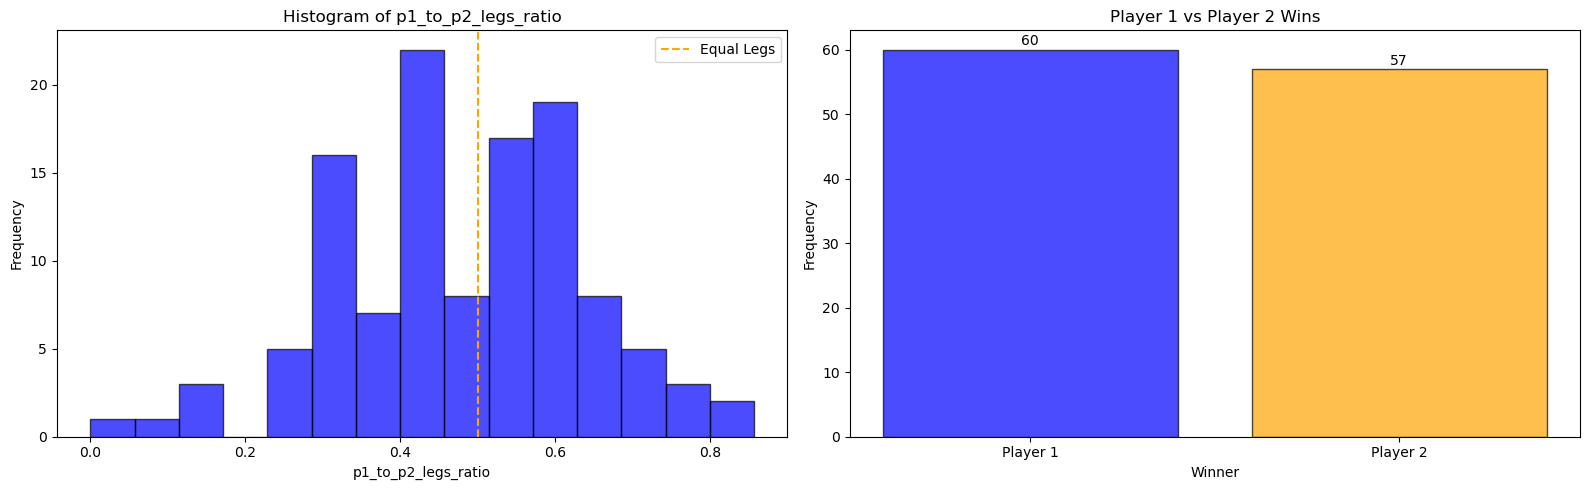

In [9]:
# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot histogram for p1_to_p2_legs_ratio on the LHS
axes[0].hist(df['p1_to_p2_legs_ratio'], bins=15, alpha=0.7, edgecolor='black', color='blue')
axes[0].set_title('Histogram of p1_to_p2_legs_ratio')
axes[0].set_xlabel('p1_to_p2_legs_ratio')
axes[0].set_ylabel('Frequency')
axes[0].axvline(0.5, color='orange', linestyle='--', label='Equal Legs')
axes[0].legend()

# Plot player1 vs player2 wins on the RHS
win_counts = df['winner'].value_counts()
bars = axes[1].bar(win_counts.index, win_counts.values, color=['blue', 'orange'], edgecolor='black', alpha=0.7)
axes[1].set_title('Player 1 vs Player 2 Wins')
axes[1].set_xlabel('Winner')
axes[1].set_ylabel('Frequency')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['Player 1', 'Player 2'])

# Add data labels to the bars
for bar in bars:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width() / 2, height + 0.2, f'{int(height)}', ha='center', va='bottom', fontsize=10)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

Similarly, with more data, the match outcome metrics show a more balanced distribution, particularly in the number of wins for `player1` and `player2`, which aligns with expectations.

### III. Relationship Between $x_{\Delta \text{ThreeDartAvg}}$, $x_{\Delta \text{CheckoutRate}}$ and Match Outcome

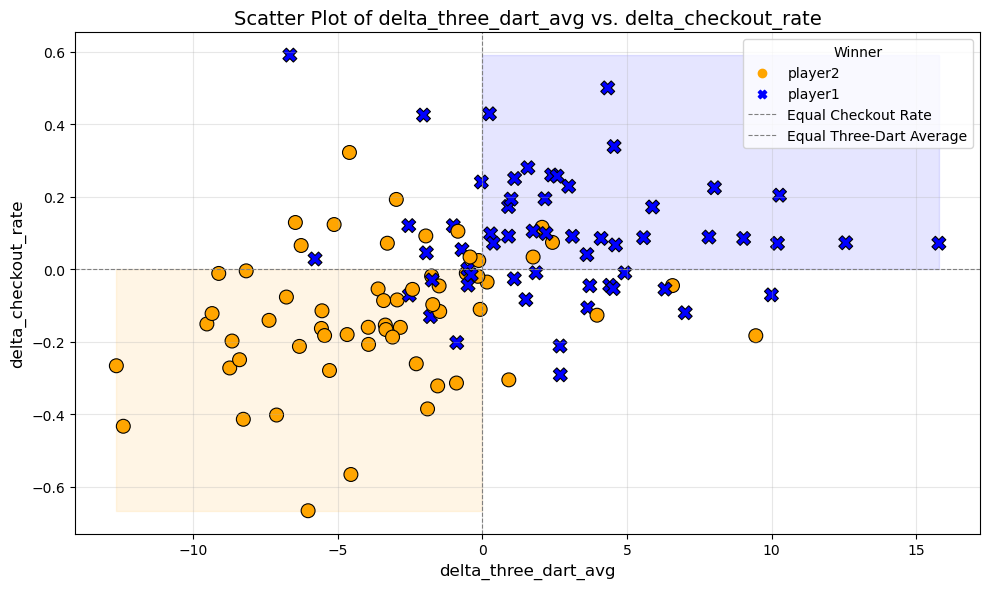

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define boundaries for shading
x_min, x_max = df['delta_three_dart_avg'].min(), df['delta_three_dart_avg'].max()
y_min, y_max = df['delta_checkout_rate'].min(), df['delta_checkout_rate'].max()

# Create a scatter plot
plt.figure(figsize=(10, 6))

# Add shaded regions for quadrantsn
plt.fill_betweenx(np.linspace(0, y_max, 500), 0, x_max, color='blue', alpha=0.1)
plt.fill_betweenx(np.linspace(y_min, 0, 500), x_min, 0, color='orange', alpha=0.1)

sns.scatterplot(
    data=df,
    x='delta_three_dart_avg',
    y='delta_checkout_rate',
    hue='winner',
    palette={'player1': 'blue', 'player2': 'orange'},
    style='winner',
    s=100,
    edgecolor='black'
)

# Add titles and labels
plt.title('Scatter Plot of delta_three_dart_avg vs. delta_checkout_rate', fontsize=14)
plt.xlabel('delta_three_dart_avg', fontsize=12)
plt.ylabel('delta_checkout_rate', fontsize=12)
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8, label='Equal Checkout Rate')
plt.axvline(0, color='gray', linestyle='--', linewidth=0.8, label='Equal Three-Dart Average')
plt.legend(title='Winner', loc='upper right')
plt.grid(alpha=0.3)

# Show plot
plt.tight_layout()
plt.show()

- With more data, the relationship between better performance metrics and a higher likelihood of winning becomes even more evident. This supports the rationale for analysing these metrics in relation to our goal of predicting match outcomes.

- Interestingly, a surprising trend emerges. In several cases, particularly near the origin where $(x_{\Delta \text{ThreeDartAvg}}, x_{\Delta \text{CheckoutRate}}) = (0, 0)$, we observe instances where **one player performed better than the other in both performance metrics, but still lost the match** [1]. 

- This counterintuitive finding warrants further investigation. As we will explore below, there is a reasonable (albeit not immediately obvious) explanation for this phenomenon [2].

[1]: *These instances are represented visually by blue crosses in the orange region and orange points in the blue region.*

[2]: *In fact, as we will shall see, this phenomenon is part of what makes darts such an exciting and unpredictable game!*

## The Paradox of Superior Performance: When Winning Metrics Don't Guarantee Victory

TO ADD:

- ~Highlight instances that fall into this category; keep the audience on the same page~
- ~Emphasise that these examples always happen close to the origin; when a player narrowly outperforms the other~
- ~Entice the audience: "... there is perhaps another variable at play, which we have not considered ..."~
- ~Dissect a specifc game / throw-by-throw / introduce the idea of "clutch" (audience may already have guessed it, especially if familiar with darts) / commonly referred to as timing~
- Evidence further with news articles / other statistics e.g. 25% time players ... 

In [41]:
# Filter matches where the "superior" player lost the match
df_unexpected = df.loc[
    ((df['delta_checkout_rate'] < 0) & (df['delta_three_dart_avg'] < 0) & (df['winner'] == "player1")) | 
    ((df['delta_checkout_rate'] > 0) & (df['delta_three_dart_avg'] > 0) & (df['winner'] == "player2"))]

# Quantify occurence frequency
print(f"Num. of total matches:       {len(df)}")
print(f"Num. of unexpected matches:  {len(df_unexpected)}")
print(f"Prop. of unexpected matches: {round(len(df_paradox) / len(df), 3)*100}%")
print("\nCases where the superior-performing player lost:")

# Preview unexpected matches
df_unexpected[["player1", "player2", "legs_score", "sets_score", "p1_three_dart_avg", 
               "p2_three_dart_avg", "p1_checkout_rate", "p2_checkout_rate", "winner"]]

Num. of total matches:       117
Num. of unexpected matches:  9
Prop. of unexpected matches: 7.7%

Cases where the superior-performing player lost:


,player1,player2,legs_score,sets_score,p1_three_dart_avg,p2_three_dart_avg,p1_checkout_rate,p2_checkout_rate,winner
28,Michael Smith,Nick Kenny,6-5,<NA>,94.26,96.06,0.285714,0.416667,player1
33,Kim Huybrechts,Scott Williams,4-6,<NA>,88.86,87.11,0.333333,0.300000,player2
37,Damon Heta,Krzysztof Ratajski,6-5,<NA>,97.36,97.86,0.250000,0.294118,player1
58,Connor Scutt,Dirk van Duijvenbode,9-10,<NA>,98.75,96.69,0.500000,0.384615,player2
64,James Wade,Cameron Menzies,9-10,<NA>,95.92,93.50,0.473684,0.400000,player2
88,Mike De Decker,Damon Heta,7-7,2-1,92.01,94.54,0.466667,0.538462,player1
117,Rob Cross,Gian van Veen,13-12,<NA>,100.42,100.81,0.464286,0.480000,player1
132,Michael Smith,Chris Dobey,11-9,<NA>,93.91,94.80,0.297297,0.500000,player1
137,Luke Humphries,James Wade,17-10,<NA>,100.64,102.38,0.404762,0.434783,player1


DRAFT

The matches above reveal unexpected outcomes where the statistically superior player still lost. Take the first match, for example, when Michael Smith faced Nick Kenny in the Players Championship Finals 2024 (Round of 64). Despite Kenny achieving a 1.8-point higher three-dart average and a 13% better checkout rate, it was Smith that emerged victorious, narrowly winning 6-5 on legs. We notice the same pattern across in the other examples, with most matches showing marginal differences in performance metrics accompanied by similarly narrow margins of victory (except, perhaps, the Humphries-Wade matchup). This reflects our earlier observation in the previous diagram, where unexpected results were most likely to occur near the origin, suggesting only minimal differences in performance metrics between players. [Something that suggests, performance metrics are fine but not tell the whole story when the difference between them is marginal]

So, if darts players can score worse and have worse checkout efficiency than their opponent yet still win—occurring roughly 8% of the time—what other factors might be influencing match outcomes that we have not considered? For darts fans, you probably saw this one coming, but it also very often comes down to none other than **timing**. In darts, it’s not just about how well you play overall, but <ins>when</ins> you deliver your best performance. It is in those clutch moments that can make all the difference whether you win or lose.